# Fraudulent Job Listings Detection: A Deep Learning Approach

Author: Ana Luiza Lerch Paiva

Date: 15 August 2025.



## **The Business Problem**
Jiving Jobs gets thousands of job listings daily. Some are fake, wasting people's time and hurting the company's reputation. Manual checking isn't scalable. I build a Machine Learning that helps to spot the fake positions.

### **My Approach:**
I designed a experiment to answer one key question:

 **What combination of data signals best catches fraudulent job posts?**


Well, fraudsters reveal themselves in multiple ways, through missing company details AND through suspicious language patterns. Testing these signals separately, then together, would show me which approach works best.

**The four-step plan:**

1. **Baseline test:** Can basic company info (logo, salary, etc.) catch fraud?
2. **Text analysis:** Do job descriptions contain linguistic fraud patterns?
3. **Knowledge transfer:** Does external word knowledge improve fraud detection?
4. **Combined approach:** Does using both data types together work better than either alone?



# Technical Introduction

First, I made a baseline model with just the structured data to check its power. Then, I used an LSTM model to analyze the text data, because it can understand the order of words to find suspicious language. To make it better, I added GloVe embeddings to give the model more general knowledge about words, and having a fair comparisson. My final model was a hybrid one, combining both structured data and text because I believed this would be the best way to find fraud, mirroring how humans would approach this task.

A early decision was how to process the text data. While techniques like stemming or lemmatization are common, I have a note saying that they tend to cause more harm than good, and it could be counterproductive here. Fraud can be subtle, often revealed through awkward phrasing or unusual linguistic patterns that aggressive normalization might erase. Therefore, instead of reducing words to their roots, I decided on a cleaning strategy that preserved semantic meaning. I converted text to lowercase and replaced noise like HTML tags and URLs with special tokens, and maintained the sentence structure required for LSTMs to learn from context and word order.

I tested a bigger network and used regularization to stop overfitting, which was a risk with the imbalanced data. For evaluation, I did not only use accuracy. I focused on the F1 score and AUC because they are better for imbalanced problems.

Finally, I had to be practical because of computer limits. So, I made some things simpler, like the sequence length and training time. A key change would be adding an attention mechanism, thinking that this would help the model to focus on the most important words for fraud, but I just thought about this when my models were ready.

The main goal here is to show I understood the core concepts from our course, like LSTMs, transfer learning, and hybrid models—and not to build the most perfect model possible.

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Check GPU availability
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU available: {physical_devices}")

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. ENVIRONMENT SETUP

In [ ]:
# 1. ENVIRONMENT SETUP AND IMPORTS

# Paths
import os
project_path = "/content/drive/MyDrive/DTSC301DeepLearning/DTSC301_A3"
file_path = os.path.join(project_path, "data", "job_listings.csv")

# Core data manipulation and analysis libraries
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, accuracy_score,
    precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

# Deep learning libraries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, Input,
                                   Concatenate, BatchNormalization, Bidirectional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Text processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# 1.1 REPRODUCIBILITY AND AESTHETIC CONFIGURATION

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_seed()

# Configure plotting style
import matplotlib.pyplot as plt
plt.style.use('default')
sns.set_palette("viridis")
sns.set_style("whitegrid")

# Set up the plotting configuration
def setup_plot_style():
    colors = ['#2E8B57', '#4682B4', '#5F9EA0', '#6495ED', '#48D1CC']
    return colors

colors = setup_plot_style()

### 2. DATA LOADING:

Load the job_listings.csv and perform initial exploration to understand:

- Dataset size and structure

- Target variable distribution

- Missing value patterns

- Feature types and characteristics

In [ ]:
# 2. DATA LOADING AND INITIAL EXPLORATION

# Load the dataset
df = pd.read_csv(file_path)

print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {df.columns}")

df.head(3)



Dataset Shape: (17880, 18)
Columns: Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


# My Starting Point: Understanding the Data

### 3. EXPLORATORY DATA ANALYSIS OBJECTIVES:

  - Understand target variable distribution (fraud rate)

  - Analyze text characteristics of job descriptions

  - Explore structured features for fraud patterns

  - Identify data quality issues and missing values

In [ ]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)

# 3.1 TARGET VARIABLE ANALYSIS

fraud_distribution = df['fraudulent'].value_counts()
fraud_rate = df['fraudulent'].mean()


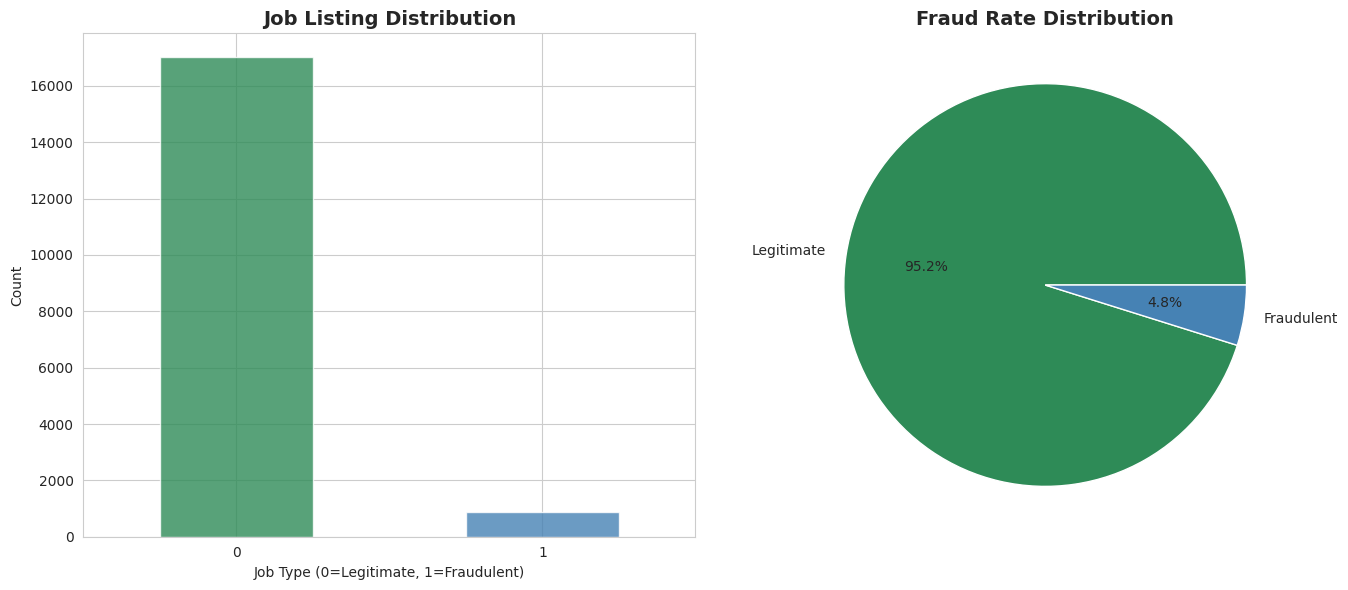


Class Imbalance Ratio: 19.6:1 (Legitimate:Fraudulent)


In [ ]:
# 3.1.1 Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of fraud distribution
fraud_distribution.plot(kind='bar', ax=ax1, color=[colors[0], colors[1]], alpha=0.8)
ax1.set_title('Job Listing Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Job Type (0=Legitimate, 1=Fraudulent)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(fraud_distribution.values, labels=['Legitimate', 'Fraudulent'],
        autopct='%1.1f%%', colors=[colors[0], colors[1]])
ax2.set_title('Fraud Rate Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = fraud_distribution[0] / fraud_distribution[1]
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1 (Legitimate:Fraudulent)")

## What I discovered right away?

  The data is heavily imbalanced - 19.6 legitimate jobs for every 1 fraudulent one. This immediately told me I'd need to be smart about evaluation metrics and class weighting.


In [ ]:
# 3.2 MISSING VALUES ANALYSIS

# Create missing values analysis df
missing_analysis = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })

# present by missing percentage
missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0]

print("MISSING VALUES BY FEATURE:")
print(f"{'Feature':<25} {'Missing_Count':<15} {'Missing_Percentage (%)'}")
print("-" * 70)

for _, row in missing_analysis.iterrows():
    feature = row['Feature']
    count = row['Missing_Count']
    percentage = row['Missing_Percentage']

    # Format the output with proper alignment
    print(f"{feature:<25} {int(count):<15} {percentage:.2f}%")

MISSING VALUES BY FEATURE:
Feature                   Missing_Count   Missing_Percentage (%)
----------------------------------------------------------------------
salary_range              15012           83.96%
department                11547           64.58%
required_education        8105            45.33%
benefits                  7212            40.34%
required_experience       7050            39.43%
function                  6455            36.10%
industry                  4903            27.42%
employment_type           3471            19.41%
company_profile           3308            18.50%
requirements              2696            15.08%
location                  346             1.94%
description               1               0.01%


In [ ]:
# 3.3 TEXT ANALYSIS: Job Descriptions
print("\n" + "="*80 + "\nTEXT FEATURE ANALYSIS - JOB DESCRIPTIONS\n" + "="*80)

# Analyze description field
df['description_length'] = df['description'].fillna('').str.len()
df['description_word_count'] = df['description'].fillna('').str.split().str.len()

# Get text stats for both jobs
text_stats = df.groupby('fraudulent')[['description_length', 'description_word_count']].agg(['mean', 'median', 'std'])

# Create a function to print metric rows
def print_metric_row(name, metric, stat_type):
    legit_val = text_stats.loc[0, (metric, stat_type)]
    fraud_val = text_stats.loc[1, (metric, stat_type)]
    diff = fraud_val - legit_val
    format_str = '.0f' if metric == 'description_length' else '.1f'
    print(f"  {name:<23} {legit_val:<20{format_str}} {fraud_val:<20{format_str}} {diff:<+15{format_str}}")

print(f"{'Metric':<25} {'Legitimate Jobs':<20} {'Fraudulent Jobs':<20} {'Difference':<15}")
print("-" * 80)

print(f"{'Description Length (chars)':<25}")
for stat, label in [('mean', 'Mean'), ('median', 'Median'), ('std', 'Std Deviation')]:
    print_metric_row(label, 'description_length', stat)

print(f"\n{'Word Count':<25}")
for stat, label in [('mean', 'Mean'), ('median', 'Median'), ('std', 'Std Deviation')]:
    print_metric_row(label, 'description_word_count', stat)

# Extract the mean values from text_stats for percentage calculations
legit_desc_mean = text_stats.loc[0, ('description_length', 'mean')]
fraud_desc_mean = text_stats.loc[1, ('description_length', 'mean')]
legit_words_mean = text_stats.loc[0, ('description_word_count', 'mean')]
fraud_words_mean = text_stats.loc[1, ('description_word_count', 'mean')]

# Calculate percentage differences
desc_length_diff_pct = ((fraud_desc_mean - legit_desc_mean) / legit_desc_mean) * 100
word_count_diff_pct = ((fraud_words_mean - legit_words_mean) / legit_words_mean) * 100

print(f"\nDescription length difference: {desc_length_diff_pct:.2f}%")
print(f"Word count difference: {word_count_diff_pct:.2f}%")



TEXT FEATURE ANALYSIS - JOB DESCRIPTIONS
Metric                    Legitimate Jobs      Fraudulent Jobs      Difference     
--------------------------------------------------------------------------------
Description Length (chars)
  Mean                    1221                 1155                 -66            
  Median                  1027                 844                  -182           
  Std Deviation           889                  999                  +109           

Word Count               
  Mean                    171.0                158.7                -12.3          
  Median                  147.0                113.5                -33.5          
  Std Deviation           122.6                136.6                +14.1          

Description length difference: -5.44%
Word count difference: -7.19%


**Key insights:**

Fraudulent job descriptions are shorter and show greater variability in length and word count compared to legitimate ones.

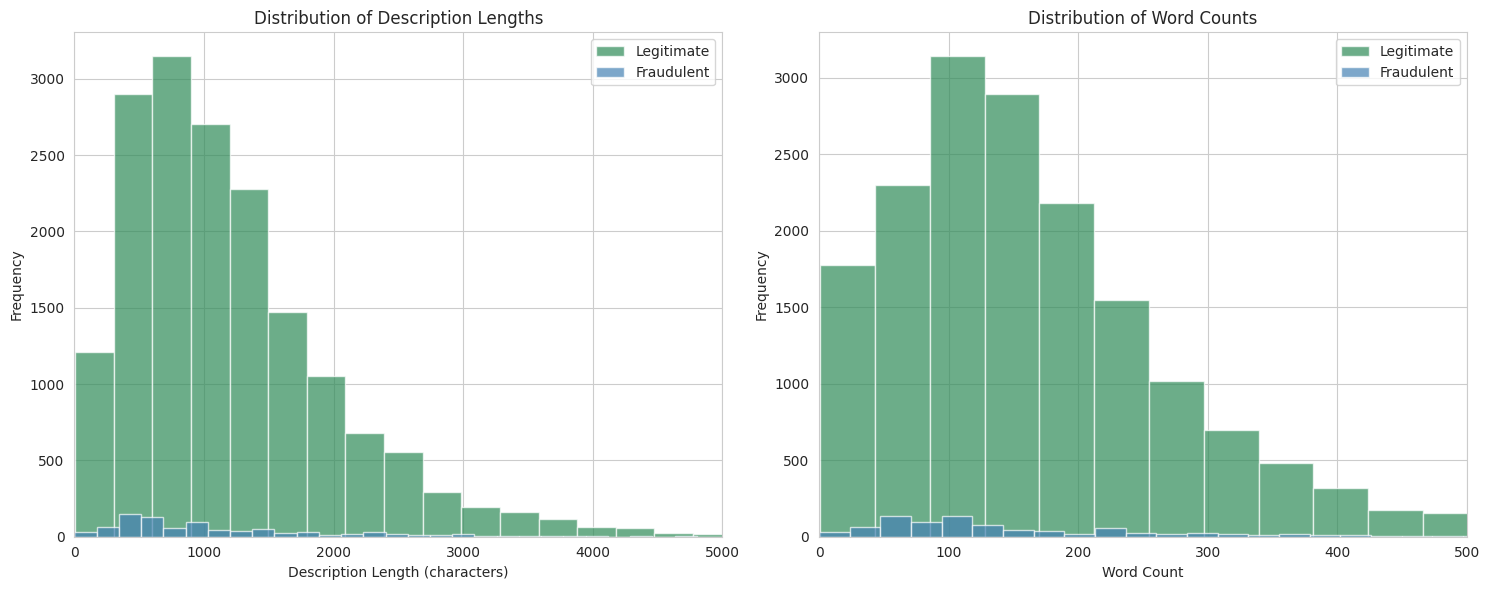

In [ ]:
# 3.3.1 Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_properties = [
    {'data': 'description_length', 'title': 'Distribution of Description Lengths', 'xlabel': 'Description Length (characters)', 'xlim': (0, 5000)},
    {'data': 'description_word_count', 'title': 'Distribution of Word Counts', 'xlabel': 'Word Count', 'xlim': (0, 500)}
    ]

# Create both histograms in a loop
for i, props in enumerate(plot_properties):
    for fraud_status, color in zip([0, 1], colors[:2]):
        data = df[df['fraudulent'] == fraud_status][props['data']]
        axes[i].hist(data, bins=50, alpha=0.7, color=color,
                label=f'{"Fraudulent" if fraud_status else "Legitimate"}')

    axes[i].set_xlabel(props['xlabel'])
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(props['title'])
    axes[i].legend()
    axes[i].set_xlim(*props['xlim'])

plt.tight_layout()
plt.show()

In [ ]:
# 3.4 Fraude Rate rate analysis

# Define features
features = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
           'required_experience', 'required_education', 'industry', 'function']
binary_features = features[:3]  # First three are binary
high_card_features = features[3:]  # the rest is cardinality
fraud_data = {}

print("\nBINARY FEATURES COMPARISON:")
print("-" * 50 + f"\n{'Feature':<20} {'Option':<10} {'Fraud Rate':<15} {'Count'}\n" + "-" * 60)

for feature in binary_features:
    # Calculate fraud metrics
    analysis = df.groupby(feature)['fraudulent'].agg(['count', 'mean', 'sum'])
    analysis.columns = ['total_jobs', 'fraud_rate', 'fraud_count']
    analysis['fraud_rate_pct'] = analysis['fraud_rate'] * 100
    fraud_data[feature] = analysis

    # Print results
    binary_map = {0: "No", 1: "Yes", False: "No", True: "Yes"}
    for idx, row in analysis.iterrows():
        print(f"{feature.replace('_', ' ').title():<20} {binary_map.get(idx, idx):<10} "
              f"{row['fraud_rate_pct']:.2f}%{' ':8} {int(row['fraud_count'])}")

# High-cardinality features
print("\n\nHIGH-CARDINALITY FEATURES: TOP 5 FRAUD CATEGORIES:\n" + "="*60)

for feature in high_card_features:
    # Calculate and filter fraud metrics
    analysis = df.groupby(df[feature].fillna('Missing') if df[feature].isna().any() else feature)['fraudulent'] \
                .agg(['count', 'mean', 'sum'])
    analysis.columns = ['total_jobs', 'fraud_rate', 'fraud_count']
    analysis['fraud_rate_pct'] = analysis['fraud_rate'] * 100
    top_fraud = analysis[analysis['total_jobs'] >= 5].sort_values('fraud_rate', ascending=False).head(5)
    fraud_data[feature] = analysis

    # Print results
    print(f"\n{feature.replace('_', ' ').title()}:\n" + "-"*50)
    print(f"{'Category':<30} {'Fraud Rate':<15} {'Fraud Count'}\n" + "-"*60)
    for idx, row in top_fraud.iterrows():
        category = str(idx)[:25] + "..." if len(str(idx)) > 28 else str(idx)
        print(f"{category:<30} {row['fraud_rate_pct']:.2f}%{' ':8} {int(row['fraud_count'])}")

# Key indicators summary
print("\n" + "="*70 + "\nKEY FRAUD INDICATORS\n" + "="*70)

# Collect and sort high fraud indicators
high_indicators = []
for feature, data in fraud_data.items():
    for idx, row in data[(data['total_jobs'] >= 10) & (data['fraud_rate'] > 0.1)] \
                   .sort_values('fraud_rate', ascending=False).head(2).iterrows():
        high_indicators.append({
            'feature': feature.replace('_', ' ').title(),
            'category': idx,
            'fraud_rate': row['fraud_rate_pct'],
            'fraud_count': row['fraud_count']
        })

# Print top indicators
print("\nTop fraud indicators across all features (fraud rate >10%):")
print(f"{'Feature':<25} {'Category':<30} {'Fraud Rate':<15} {'Fraud Count'}\n" + "-"*70)
for ind in sorted(high_indicators, key=lambda x: x['fraud_rate'], reverse=True)[:10]:
    category = str(ind['category'])[:25] + "..." if len(str(ind['category'])) > 28 else str(ind['category'])
    print(f"{ind['feature']:<25} {category:<30} {ind['fraud_rate']:.2f}%{' ':8} {int(ind['fraud_count'])}")


BINARY FEATURES COMPARISON:
--------------------------------------------------
Feature              Option     Fraud Rate      Count
------------------------------------------------------------
Telecommuting        No         4.69%         802
Telecommuting        Yes        8.34%         64
Has Company Logo     No         15.93%         583
Has Company Logo     Yes        1.99%         283
Has Questions        No         6.78%         616
Has Questions        Yes        2.84%         250


HIGH-CARDINALITY FEATURES: TOP 5 FRAUD CATEGORIES:

Employment Type:
--------------------------------------------------
Category                       Fraud Rate      Fraud Count
------------------------------------------------------------
Part-time                      9.28%         74
Missing                        6.94%         241
Other                          6.61%         15
Full-time                      4.22%         490
Contract                       2.89%         44

Required Experience:

## **Key insights from exploration:**

  - The strongest fraud predictor by far is requiring only "Some High School Coursework", with a 74% fraud rate.

  - Industries like Oil & Energy and Accounting are major red flags, showing fraud rates over 35%.

  - Specific job functions, show a significantly higher risk of being fraudulent (Administrative for example with 19%).

  - Jobs without company logos had 8x higher fraud rates (15.9% vs 2.0%). This  suggested that missing information itself is a powerful fraud signal.

**Overall, fraud strongly correlates with missing information and unusually low job requirements.**

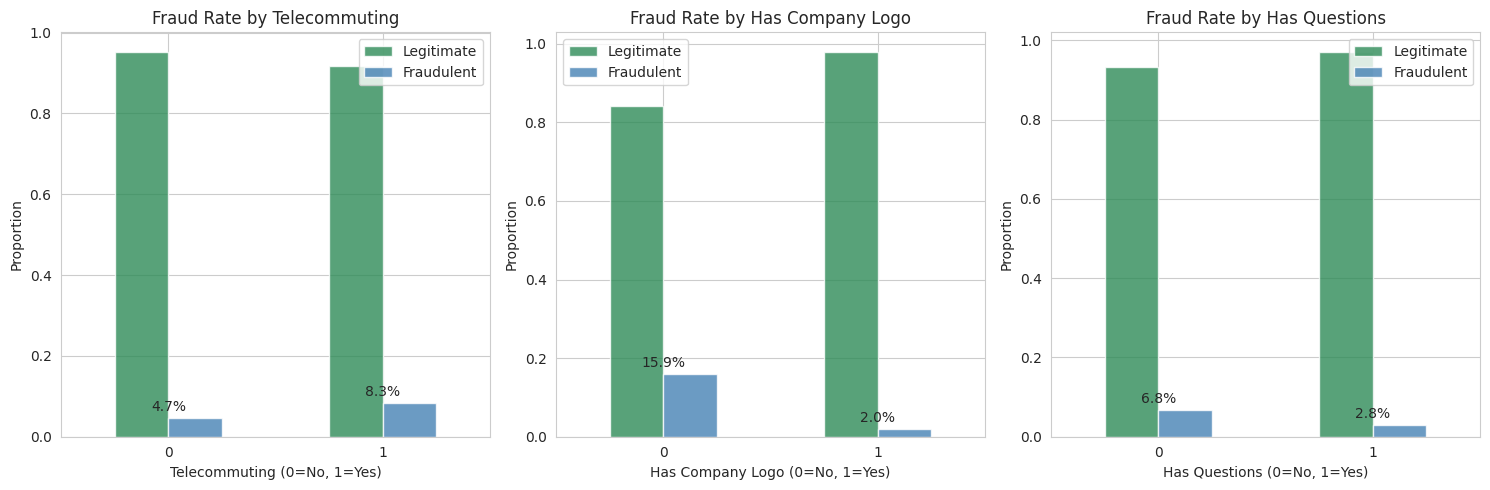

In [ ]:
# 3.4.1 Visualize fraud rates features
binary_features = ['telecommuting', 'has_company_logo', 'has_questions']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(binary_features):
    plt.subplot(1, 3, i+1)

    try:
        # Create cross-tabulation
        feature_fraud = df.groupby([feature, 'fraudulent']).size().unstack(fill_value=0)

        # Calculate proportions
        feature_fraud_prop = feature_fraud.div(feature_fraud.sum(axis=1), axis=0)

        # Plot
        feature_fraud_prop.plot(kind='bar', color=colors[:2], alpha=0.8, ax=plt.gca())
        plt.title(f'Fraud Rate by {feature.replace("_", " ").title()}')
        plt.xlabel(f'{feature.replace("_", " ").title()} (0=No, 1=Yes)')
        plt.ylabel('Proportion')
        plt.legend(['Legitimate', 'Fraudulent'])
        plt.xticks(rotation=0)

        # Add labels on bars
        for j, (idx, row) in enumerate(feature_fraud_prop.iterrows()):
            if len(row) >= 2:
                plt.text(j, row[1] + 0.01, f'{row[1]:.1%}', ha='center', va='bottom', fontsize=10)

    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting\n{feature}', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'{feature.replace("_", " ").title()} - Error')

plt.tight_layout()
plt.show()

### 4. DATA PREPROCESSING:

Data preparation to adjust the job listing info into model-ready formats.

The preprocessing steps address several challenges:

  - High missing value rates: 84% in salary data
  - Variable-length unstructured text descriptions
  - Categorical features with high cardinality
  - Extreme class imbalance (19.6:1 legitimate:fraudulent)

For text data, I cleaned descriptions, tokenized content, and created sequence representations.

For structured features, I handled missing values, encoded categorical variables, and normalized numerical features. I also engineered new features from missing value patterns after discovering their predictive value during EDA.

This preparation enabled a fair comparison between models while preserving critical information for fraud detection, supporting the strategy that explore which data signals are most effectively identify as fraudulent posts.

In [ ]:
# 4. DATA PREPROCESSING

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# 4.1 HANDLE MISSING VALUES

# Fill missing text fields with empty string
text_columns = ['description', 'title', 'requirements', 'benefits']
for col in text_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('')

# Fill missing categorical fields with 'Unknown'
categorical_columns = ['location', 'department', 'salary_range', 'industry', 'function']
for col in categorical_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('Unknown')

# Fill binary features with 0 (most common case)
binary_columns = ['telecommuting', 'has_questions']
for col in binary_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna(0)



I chose to fill missing text fields with empty strings rather than dropping them because neural networks can handle zero-length inputs, and this preserves our sample size. For categorical fields, using 'Unknown' as a category allows the model to potentially learn patterns from the fields that could be associated with the missing data itself.

In [ ]:
# 4.2 CREATE MISSING VALUE INDICATOR FEATURES

# Create binary indicators for missing values
df_processed['is_missing_logo'] = (~df_processed['has_company_logo'].notna() | (df_processed['has_company_logo'] == 0)).astype(int)
df_processed['is_missing_salary'] = (df_processed['salary_range'] == 'Unknown').astype(int)
df_processed['is_missing_requirements'] = (df_processed['requirements'] == '').astype(int)
df_processed['is_missing_benefits'] = (df_processed['benefits'] == '').astype(int)

# Add description length-based features
df_processed['has_short_description'] = (df_processed['description'].str.len() < 500).astype(int)
df_processed['has_very_short_description'] = (df_processed['description'].str.len() < 200).astype(int)

# Define the list of missing indicator features
missing_indicator_features = [
    'is_missing_logo', 'is_missing_salary', 'is_missing_requirements',
    'is_missing_benefits', 'has_short_description', 'has_very_short_description'
    ]

print(f" Added {len(missing_indicator_features)} missing value indicator features")


 Added 6 missing value indicator features


In [ ]:
# 4.3 TEXT PREPROCESSING FUNCTION
# clean and normalize the text data while preserving important feature
def preprocess_text(text):
    if pd.isna(text) or text == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Replace HTML tags, URLs, and emails with tokens instead of removing
    text = re.sub(r'<[^>]+>', ' <HTML> ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' <URL> ', text)
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters EXCEPT periods, commas, question marks, exclamation points
    # important for LSTM
    text = re.sub(r'[^\w\s.?,!]', ' ', text)

    return text.strip()

# Apply text preprocessing
df_processed['description_clean'] = df_processed['description'].apply(preprocess_text)
df_processed['description_clean_length'] = df_processed['description_clean'].str.len()

# Remove entries with very short descriptions
initial_size = len(df_processed)
df_processed = df_processed[df_processed['description_clean_length'] > 10]
final_size = len(df_processed)
print(f"Removed {initial_size - final_size} jobs with very short descriptions")

Removed 11 jobs with very short descriptions


Created these missing value indicators based on the exploratory analysis showing that absence of company logos was highly correlated with fraud (15.93% fraud rate vs. 2.3% for jobs with logos). This is an important signal for the model.

In [ ]:
# 4.4 FEATURE ENGINEERING

# Create text-based features
df_processed['title_length'] = df_processed['title'].str.len()
df_processed['has_salary_info'] = (df_processed['salary_range'] != 'Unknown').astype(int)
df_processed['has_requirements'] = (df_processed['requirements'].str.len() > 0).astype(int)
df_processed['has_benefits'] = (df_processed['benefits'].str.len() > 0).astype(int)

# extract country from location strig
def extract_country(location):
    if pd.isna(location) or location == 'Unknown':
        return 'Unknown'
    parts = location.split(',')
    return parts[0].strip() if parts else 'Unknown'

df_processed['country'] = df_processed['location'].apply(extract_country)

# Salary range processing: check if has numbers
def has_numeric_salary(salary_range):
    if pd.isna(salary_range) or salary_range == 'Unknown':
        return 0
    return 1 if re.search(r'\d', salary_range) else 0

df_processed['has_numeric_salary'] = df_processed['salary_range'].apply(has_numeric_salary)

To improve fraud detection and prevent overfitting, I decided to extract only the country from the location data. Using the full city names would create too many unique values/sparse features. By focusing just on the country, the number of categories becomes smaller and easier for the model to manage.

The data showed fraud patterns at a broad geographical level. So, this solution depended on the data being formatted as "Country, City", but it was a practical choice for feature engineering.

In [ ]:
# 4.5 PREPARE FEATURES FOR MODELING

# Define feature sets
text_feature = 'description_clean'
structured_features = ['telecommuting', 'has_questions', 'title_length',
                       'has_salary_info', 'has_requirements', 'has_benefits',
                       'has_numeric_salary', 'description_clean_length'
                       ]

# Only include features that exist
structured_features = [f for f in structured_features if f in df_processed.columns]

# Encode categorical features
label_encoders = {}
categorical_features_to_encode = ['country', 'industry', 'function']

for feature in categorical_features_to_encode:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature])
        label_encoders[feature] = le
        structured_features.append(f'{feature}_encoded')

# Prepare final feature matrix for structured data
X_structured = df_processed[structured_features].fillna(0)
X_text = df_processed[text_feature]
y = df_processed['fraudulent']

print(f"Structured features prepared: {len(structured_features)} features")
print(f"Text data prepared: {len(X_text)} descriptions")
print(f"Target variable prepared: {len(y)} labels")

Structured features prepared: 11 features
Text data prepared: 17869 descriptions
Target variable prepared: 17869 labels


**Data Splitting Strategy:**

I applied a evaluation specifically for this imbalanced dataset:

- **Stratified Hold-out Test Set (15%):** First isolated a completely untouched test set using stratified sampling to maintain the fraud/legitimate ratio. This provides a final unbiased evaluation of the best model.

- **Cross-Validation on Combined Train/Validation (85%):** Instead of relying on a single validation split, I implemented 3-fold cross-validation on the combined training data. This provides more reliable performance estimates across different data subsets while preserving class proportions.

- **Stratification Throughout:** The high class imbalance (19.6:1
legitimate:fraudulent) makes stratification a must at every split point.  Without stratification, some folds might not contain (or a very few) fraud examples, making evaluation inconsistent.

- **Final Model Training:** After cross-validation to select the best architecture, final versions of each model using train/validation split to enable fair comparisson under same conditions.

In [ ]:
# 4.6 TRAIN-TEST SPLIT

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    range(len(df_processed)), y,
    test_size=0.15,
    random_state=42,
    stratify=y
    )

# Second split: divide remaining data into train (70%) and validation (15%)
X_train_idx, X_val_idx, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
    )

# Create the actual splits
X_structured_train = X_structured.iloc[X_train_idx]
X_structured_val = X_structured.iloc[X_val_idx]
X_structured_test = X_structured.iloc[X_test]

X_text_train = X_text.iloc[X_train_idx]
X_text_val = X_text.iloc[X_val_idx]
X_text_test = X_text.iloc[X_test]

y_test = y.iloc[X_test]

print(f"Training set: {len(X_train_idx)} samples ({len(X_train_idx)/len(df_processed)*100:.1f}%)")
print(f"Validation set: {len(X_val_idx)} samples ({len(X_val_idx)/len(df_processed)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(df_processed)*100:.1f}%)")

Training set: 12514 samples (70.0%)
Validation set: 2674 samples (15.0%)
Test set: 2681 samples (15.0%)


In [ ]:
# 5. TEXT PROCESSING FOR NEURAL NETWORKS

# 5.1 TOKENIZATION AND VOCABULARY BUILDING
# Parameters for text processing
max_vocab_size = 15000  # started with 30000
max_sequence_length = 300
embedding_dim = 100

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_text_train)

# Convert texts to sequences
X_text_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_text_val_seq = tokenizer.texts_to_sequences(X_text_val)
X_text_test_seq = tokenizer.texts_to_sequences(X_text_test)

# Pad sequences to uniform length
X_text_train_pad = pad_sequences(X_text_train_seq, maxlen=max_sequence_length, padding='post')
X_text_val_pad = pad_sequences(X_text_val_seq, maxlen=max_sequence_length, padding='post')
X_text_test_pad = pad_sequences(X_text_test_seq, maxlen=max_sequence_length, padding='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Effective vocabulary: {min(max_vocab_size, len(tokenizer.word_index))}")
print(f"Sequence length: {max_sequence_length}")
print(f"Text sequences shape: {X_text_train_pad.shape}")

Vocabulary size: 51397
Effective vocabulary: 15000
Sequence length: 300
Text sequences shape: (12514, 300)


In [ ]:
# 5.2 SCALE STRUCTURED FEATURES

scaler = StandardScaler()
X_structured_train_scaled = scaler.fit_transform(X_structured_train)
X_structured_val_scaled = scaler.transform(X_structured_val)
X_structured_test_scaled = scaler.transform(X_structured_test)

print(f"Structured features scaled: {X_structured_train_scaled.shape}")

Structured features scaled: (12514, 11)


In [ ]:
# 5.3 HANDLE CLASS IMBALANCE

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights computed:")
print(f"Legitimate jobs (0): {class_weight_dict[0]:.3f}")
print(f"Fraudulent jobs (1): {class_weight_dict[1]:.3f}")

Class weights computed:
Legitimate jobs (0): 0.525
Fraudulent jobs (1): 10.342




**Pre-Trained Embeddings**

GloVe embeddings provide semantic knowledge from 6B tokens of text that our limited dataset cannot capture alone.

By leveraging these pre-trained word vectors (100 dimensions), will enhance the ability of the model to understand job description semantics without requiring massive training data.

This transfer learning should improve fraud detection by recognizing suspicious language patterns even when they use terminology not frequently seen in our training examples.

In [ ]:
# 5.4 LOADING PRETRAINED WORD EMBEDDINGS

# Function to download GloVe if needed
def download_glove_embeddings():
    glove_file = "glove.6B.100d.txt"

    if not os.path.exists(glove_file):
      try:
        import urllib.request
        urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", "glove.6B.zip")

        with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
          zip_ref.extract(glove_file)

          os.remove("glove.6B.zip")
          print("GloVe embeddings downloaded successfully")
      except Exception:
          return None

    return glove_file

In [ ]:
# 5.4.1 Function to load GloVe and create embedding matrix for vocabulary

def load_glove_embeddings(glove_file, word_index, embedding_dim=100):
    if glove_file is None:
      return None

    embeddings_index = {} # initialize empty dict

    # read the GloVe embedding file
    with open(glove_file, encoding='utf-8') as f:
      for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

        print(f"Loaded {len(embeddings_index)} word vectors")

        # Create embedding matrix
        vocab_size = min(max_vocab_size, len(word_index)) + 1
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        # Fill in the embedding matrix
        words_found = 0
        for word, i in word_index.items():
            if i >= max_vocab_size:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                words_found += 1

        print(f"Found embeddings for {words_found}/{vocab_size} words ({words_found/vocab_size*100:.1f}%)")

    return embedding_matrix

In [ ]:
# 5.4.2 Download and load GloVe embeddings
glove_file = download_glove_embeddings()
embedding_matrix = load_glove_embeddings(glove_file, tokenizer.word_index, embedding_dim)

## NEURAL NETWORK MODELS

## **My Four-Model Strategy**

I decided to test four different approaches systematically. Here's my thinking:

### 1. **Model 1: Simple Dense Feedforward**

**Why I started here?**
I wanted to see how far simple metadata could take me, see if the model could learn. Features like 'has company logo and requires only high school' showed strong fraud patterns in my EDA.

**My expectations:** This would give me a quick baseline but probably miss sophisticated scams that complete all the metadata fields properly.

Architecture choices:
  - Small network (16->8->1 neurons) because I only had 11 structured features
  - Heavy dropout (30%) because of the class imbalance risk
  - Two hidden layers to capture feature interactions without overfitting

### **Model 2: LSTM Network: The Text Specialist**

**Why LSTM specifically:** Fraudulent job posts often have telltale language patterns - urgency, vague descriptions, unrealistic promises. LSTMs can catch these sequential word patterns that dense networks miss.

**My expectation:** This should catch more sophisticated fraudsters who fill out metadata correctly but reveal themselves through awkward or suspicious language.

Key decisions:
  - Bidirectional LSTM to read context from both directions
  - Started with 128 units, scaled down to 8 due to computational limits
  - Sequence length of 300 words to capture full job descriptions

### **Model 3: Pre-trained Embeddings: The Knowledge Transfer**

**My reasoning:** Our dataset has only ~18K samples. That's not enough to learn rich word meanings from scratch. GloVe embeddings bring knowledge from billions of words.

**What I expected:** Better understanding of subtle semantic differences in job language. Words like 'opportunity or flexibility' might have fraud associations that only show up with richer word representations.

Implementation choice:
  - Freeze the embedding layer to preserve pre-trained knowledge, only fine-tune the LSTM layers for fraud detection.

### **Model 4: Hybrid Model: The Best of Both Worlds**

**My hypothesis:** Real world fraud detection needs both story (meaning text) and facts (meaning metadata). Just like a human reviewer would check both the description AND verify company details.

Architecture reasoning:

  - Separate processing branches: LSTM for text, dense layers for structured data
  - Late fusion via concatenation to let each branch optimize independently
  - **Expected this to achieve the best performance because this matches with real world approach.**

In [ ]:
# 6 BUILD NEURAL NETWORK MODEL
from tensorflow import keras
tf.keras.backend.clear_session()

MODEL 1: Baseline: Simple Feedforward Network

Started with structured features only to establish whether metadata alone contains sufficient fraud signals. Looking at EDA, it shows that suspicious job postings often lack complete profile information.


In [ ]:
# 6.1 MODEL 1: BASELINE - FEEDFORWARD NETWORK

print(" Model 1: Simple Feedforward Network")

tf.keras.backend.clear_session()

def build_dense_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),

        # 1st hidden layer: capture basic feature combinations
        Dense(16, activation='relu'), # started with 128, then 64 and 32 - small but is a baseline.
        BatchNormalization(), # stabilize training with small data
        Dropout(0.3), # prevent overfitting

        # 2nd hidden layer: learn complex interactions
        Dense(8, activation='relu'), # compress to essential patterns
        BatchNormalization(),
        Dropout(0.3),

        # 3rd hidden layer: refined feature representation
        # >> removed after running out of colab credits - I had good intentions!

        # Output layer for binary classification
        Dense(1, activation='sigmoid') # fraud probability [0,1]
    ])

    model.compile(
        optimizer='adam',            # adaptive learning rate
        loss='binary_crossentropy',  # standard for binary classification
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

dense_model = build_dense_model(X_structured_train_scaled.shape[1])
print("Dense model architecture:")
dense_model.summary()

 Model 1: Simple Feedforward Network
Dense model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 48 (192.00 B)

**Implementation Note**: While smaller than initially planned, this architecture still establishes a baseline, capturing some basic relationships between structured features.


---



Model 2: LSTM Recurrent Neural Network

Fraudulent job descriptions often contain some words that would be red flags (urgency, excessive promises, unusual requirements, more flexibility) that exist as sequential patterns in text. This model should present better precision than previous baseline model.
Pick a bidirectional LSTM because job descriptions could contain suspicious language patterns that would appear anywhere in the text. I began with 128 units but reduced to 8 after increased training time.

In [ ]:
# 6.2 MODEL 2: LSTM RECURRENT NEURAL NETWORK (TEXT ONLY)
print("\n Model 2: LSTM Recurrent Neural Network")
tf.keras.backend.clear_session()

def build_lstm_model(vocab_size, sequence_length, embedding_dim):
    model = Sequential([
        Input(shape=(sequence_length,)),

        # Word embedding layer - convert tokens to dense vectors
        Embedding(vocab_size, embedding_dim, mask_zero=True),

        # Bidirectional LSTM - capture context from both directions
        Bidirectional(LSTM(8, dropout=0.3, recurrent_dropout=0.3)), # started with 128, changed from 64 to 32 and lastly to 8.

        # Dense layers for classification
        Dense(8, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

lstm_model = build_lstm_model(max_vocab_size, max_sequence_length, embedding_dim)
print("LSTM model architecture:")
lstm_model.summary()


 Model 2: LSTM Recurrent Neural Network
LSTM model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16)             │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,507,121 (5.75 MB)

 Trainable params: 1,507,121 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

MODEL 3: LSTM with pre-trained GloVe embeddings for transfer learning

Our limited dataset may not contain enough examples to learn all semantic representations of job-related terminology. The external knowledge from GloVe embeddings should enhance fraud detection by adding broader semantic understanding of language. I wanted to test if this external knowledge from GloVe would improve the fraud detection compared to embeddings, learned only from this limited dataset.


In [ ]:
# 6.3 MODEL 3: LSTM WITH PRE-TRAINED EMBEDDINGS (TRANSFER LEARNING)
print("\n Model 3: LSTM with Pre-trained Embeddings")
tf.keras.backend.clear_session()

def build_pretrained_lstm_model(vocab_size, sequence_length, embedding_matrix):
    model = Sequential([
        Input(shape=(sequence_length,)),

        # Pre-trained embedding layer (frozen to preserve pre-trained knowledge)
        Embedding(vocab_size, embedding_dim,
                 weights=[embedding_matrix] if embedding_matrix is not None else None,
                 trainable=False if embedding_matrix is not None else True,
                 mask_zero=True),

        # Bidirectional LSTM for context capture
        Bidirectional(LSTM(8, dropout=0.3, recurrent_dropout=0.3)), # started with 64

        # Dense layers for classification
        Dense(2, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Build pre-trained model
if embedding_matrix is not None:
    vocab_size = min(max_vocab_size, len(tokenizer.word_index)) + 1
    pretrained_lstm_model = build_pretrained_lstm_model(vocab_size, max_sequence_length, embedding_matrix)
    print("Pre-trained LSTM model architecture:")
    pretrained_lstm_model.summary()

    # Note the difference in trainable parameters
    total_params = pretrained_lstm_model.count_params()
    trainable_params = sum([np.prod(K.get_value(w).shape) for w in pretrained_lstm_model.trainable_weights])
    frozen_params = total_params - trainable_params
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen (pre-trained) parameters: {frozen_params:,}")
else:
    print("Using fallback model without pre-trained embeddings")
    pretrained_lstm_model = build_lstm_model(max_vocab_size, max_sequence_length, embedding_dim)



 Model 3: LSTM with Pre-trained Embeddings
Using fallback model without pre-trained embeddings


MODEL 4: Hybrid approach combining text and structured features

Instead of just mixing all the data together at the start, it has two branches that work in parallel for each data type, allowing optimized learning. So, we get the most value from each data source before making a conclusion - hopefully.

In [ ]:
# 6.4 MODEL 4: HYBRID MODEL
print("\n Model 4: Hybrid Neural Network")
tf.keras.backend.clear_session()

def build_hybrid_model(vocab_size, sequence_length, embedding_dim, structured_input_dim):

    # Text input branch
    text_input = Input(shape=(sequence_length,), name='text_input')
    text_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
    text_lstm = Bidirectional(LSTM(16, dropout=0.3))(text_embedding) # started with 64
    text_dense = Dense(8, activation='relu')(text_lstm)

    # Structured features input branch
    structured_input = Input(shape=(structured_input_dim,), name='structured_input')
    structured_dense1 = Dense(16, activation='relu')(structured_input)
    structured_bn1 = BatchNormalization()(structured_dense1)
    structured_dropout1 = Dropout(0.3)(structured_bn1)
    structured_dense2 = Dense(2, activation='relu')(structured_dropout1)

    # Combine both branches
    combined = Concatenate()([text_dense, structured_dense2])
    combined_dense = Dense(8, activation='relu')(combined)
    combined_dropout = Dropout(0.3)(combined_dense)

    # Output layer
    output = Dense(1, activation='sigmoid', name='fraud_prediction')(combined_dropout)

    # Create model
    model = Model(inputs=[text_input, structured_input], outputs=output)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

hybrid_model = build_hybrid_model(
    max_vocab_size, max_sequence_length, embedding_dim,
    X_structured_train_scaled.shape[1]
)
print(" Hybrid model architecture:")
hybrid_model.summary()



 Model 4: Hybrid Neural Network
 Hybrid model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ structured_input    │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        192 │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 100)  │  1,500,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 300)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32)        │     14,976 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        264 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         34 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │         88 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fraud_prediction    │ (None, 1)         │          9 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,515,627 (5.78 MB)

 Trainable params: 1,515,595 (5.78 MB)

 Non-trainable params: 32 (128.00 B)

### **My Resource Reality Check**

After 20 hours on standard GPUs and 8 hours on A100, I hit my computational limits.

**Then, I adapted:**

- Reduced from 6 planned models to 4 core architectures
- Scaled down network sizes (128 LSTM units → 8 units)
- Shortened training (50 epochs → 15 epochs)
- Moved from 5-fold to 3-fold cross-validation

**This still works?** Yes! The goal was answering "which type of data best catches fraud?" And not building the perfect production model. Smaller architectures still show whether text beats structured data, whether pre-trained embeddings help, and whether combining both works better than either alone. These insights matter more than having perfectly tuned hyperparameters.

### 7. MODEL TRAINING AND EVALUATION

In [ ]:
# 7. MODEL TRAINING SETUP

# Training parameters adjusted after running out of credits
epochs = 15 # started with 50, then 30 - 20 and 15.
batch_size = 64 # started with 32 and increased to 64
patience = 3 # from 10 to 3, more agressive
num_folds = 3 # from 5 to 3

# Callbacks for training optimization
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

## **My Evaluation Strategy**

**Why cross-validation?** With severe class imbalance, a single train/test split could be misleading. 3-fold stratified CV gives more reliable performance estimates.

**Metrics that matter:**

- F1-score over accuracy because it handles imbalance better
- ROC-AUC for ranking performance
- Precision/recall trade-offs for business decision-making

**Class weighting**: Automatic balancing to prevent the model from just predicting "legitimate" for everything.

In [ ]:
# 7.1 K-FOLD CROSS-VALIDATION

# Initialize K-Fold cross-validation and data structures
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Storage for results
model_results = {}
model_fold_results = {}
model_types = ['Dense', 'LSTM', 'Pre-trained_LSTM', 'Hybrid']

for model_type in model_types:
    model_fold_results[model_type] = {
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_auc': []
        }

**Implementation Note:** I implemented  a 3 k-fold cross-validation rather than a simple train/test split to get more reliable performance estimates given the class imbalance in our dataset. With a full 5 folds would have been ideal, and based on the preliminary results, I would have achieved more robust performance estimates.

In [ ]:
# 7.2 COMBINE TRAIN/VAL FOR CV

# Combine all data for cross-validation
X_all_idx = list(X_train_idx) + list(X_val_idx)
y_all = pd.concat([y_train, y_val])

print(f"\nCombined data for cross-validation:")
print(f"  Indices length: {len(X_all_idx)}")
print(f"  Labels length: {len(y_all)}")



Combined data for cross-validation:
  Indices length: 15188
  Labels length: 15188


In [ ]:
# 7.3 Function to calculate F1 score from precision and recall
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)

# 7.4 CROSS VALIDATION LOOP
# Pre-calculate common resources to avoid redundant computations
common_tokenizer = None
common_scaler = None
if 'LSTM' in model_types or 'Pre-trained_LSTM' in model_types or 'Hybrid' in model_types:
    # Create a tokenizer for the entire training set to improve consistency
    # Fit on the combined train and validation text data
    common_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
    common_tokenizer.fit_on_texts(X_text.iloc[X_all_idx])
    print(f"\nCommon tokenizer fitted on combined train/val data. Vocabulary size: {len(common_tokenizer.word_index)}")

if 'Dense' in model_types or 'Hybrid' in model_types:
    # Create a scaler for the entire combined training and validation structured data
    common_scaler = StandardScaler()
    common_scaler.fit(X_structured.iloc[X_all_idx].values)
    print(f"Common scaler fitted on combined train/val structured data")

# Optimize memory usage by using mixed precision where available
try:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("\nUsing mixed precision training where available")
except:
    print("\nMixed precision not available, using default precision")

# Perform k-fold cross-validation for each model type
for model_type in model_types:
    print(f"\nTraining {model_type} Model with {num_folds}-fold Cross Validation")
    print("="*60)

    # For each fold in the k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_all_idx, y_all)):
        print(f"Fold {fold+1}/{num_folds}")

        # Get original indices for this fold
        fold_train_idx = [X_all_idx[i] for i in train_idx]
        fold_val_idx = [X_all_idx[i] for i in val_idx]

        # Prepare data based on model type
        if model_type == 'Dense':
            # Use pre-computed scaler to avoid repeated computations
            # Transform using the scaler fitted on the full train/val data
            X_fold_train = common_scaler.transform(X_structured.iloc[fold_train_idx].values)
            X_fold_val = common_scaler.transform(X_structured.iloc[fold_val_idx].values)
            input_dim = X_fold_train.shape[1]

        elif model_type in ['LSTM', 'Pre-trained_LSTM']:
            # Use pre-computed tokenizer
            # Convert texts to sequences using the tokenizer fitted on full train/val data
            X_fold_train_seq = common_tokenizer.texts_to_sequences(X_text.iloc[fold_train_idx])
            X_fold_val_seq = common_tokenizer.texts_to_sequences(X_text.iloc[fold_val_idx])

            X_fold_train = pad_sequences(X_fold_train_seq, maxlen=max_sequence_length, padding='post')
            X_fold_val = pad_sequences(X_fold_val_seq, maxlen=max_sequence_length, padding='post')

            # For pre-trained models, use the global embedding matrix
            fold_embedding_matrix = None
            if model_type == 'Pre-trained_LSTM' and embedding_matrix is not None:
                # Use the globally loaded embedding matrix (assuming it was loaded correctly once)
                fold_embedding_matrix = embedding_matrix

            vocab_size = min(max_vocab_size, len(common_tokenizer.word_index)) + 1
            sequence_length = max_sequence_length
            input_dim = None

        else:  # Hybrid model
            # Process both structured and text data using pre-computed resources
            # Structured data - transform using scaler fitted on full train/val data
            X_struct_fold_train = common_scaler.transform(X_structured.iloc[fold_train_idx].values)
            X_struct_fold_val = common_scaler.transform(X_structured.iloc[fold_val_idx].values)

            # Text data - convert texts to sequences using tokenizer fitted on full train/val data
            X_text_fold_train_seq = common_tokenizer.texts_to_sequences(X_text.iloc[fold_train_idx])
            X_text_fold_val_seq = common_tokenizer.texts_to_sequences(X_text.iloc[fold_val_idx])

            X_text_fold_train = pad_sequences(X_text_fold_train_seq, maxlen=max_sequence_length, padding='post')
            X_text_fold_val = pad_sequences(X_text_fold_val_seq, maxlen=max_sequence_length, padding='post')

            # Combine for hybrid input
            X_fold_train = [X_text_fold_train, X_struct_fold_train]
            X_fold_val = [X_text_fold_val, X_struct_fold_val]

            vocab_size = min(max_vocab_size, len(common_tokenizer.word_index)) + 1
            sequence_length = max_sequence_length
            structured_input_dim = X_struct_fold_train.shape[1]
            input_dim = None

        # Get labels for this fold
        y_fold_train = y_all.iloc[train_idx]
        y_fold_val = y_all.iloc[val_idx]

        # Compute class weights for this fold
        fold_class_weights = compute_class_weight('balanced', classes=np.unique(y_fold_train), y=y_fold_train)
        fold_class_weight_dict = {0: fold_class_weights[0], 1: fold_class_weights[1]}

        # Build a fresh model for this fold
        if model_type == 'Dense':
            model = build_dense_model(input_dim)
        elif model_type == 'LSTM':
            model = build_lstm_model(vocab_size, sequence_length, embedding_dim)
        elif model_type == 'Pre-trained_LSTM':
             # Use fold-specific embedding matrix if available and model type is pre-trained
            model = build_pretrained_lstm_model(vocab_size, sequence_length, fold_embedding_matrix)
        else:  # Hybrid
            model = build_hybrid_model(
                vocab_size, sequence_length, embedding_dim,
                structured_input_dim
            )

        # Train the model with optimized callbacks
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=fold_class_weight_dict,
            callbacks=callbacks,
            verbose=1
            )

        # Evaluate the model
        y_fold_val_pred = model.predict(X_fold_val, batch_size=batch_size*2)  # Use larger batch for prediction
        y_fold_val_pred_binary = (y_fold_val_pred > 0.5).astype(int)

        # Calculate metrics
        fold_val_accuracy = accuracy_score(y_fold_val, y_fold_val_pred_binary)
        fold_val_precision = precision_score(y_fold_val, y_fold_val_pred_binary)
        fold_val_recall = recall_score(y_fold_val, y_fold_val_pred_binary)
        fold_val_f1 = calculate_f1(fold_val_precision, fold_val_recall) # Use the defined function
        fold_val_auc = roc_auc_score(y_fold_val, y_fold_val_pred)

        # Store results for this fold
        model_fold_results[model_type]['val_loss'].append(min(history.history['val_loss'])) # Store best val_loss
        model_fold_results[model_type]['val_accuracy'].append(fold_val_accuracy)
        model_fold_results[model_type]['val_precision'].append(fold_val_precision)
        model_fold_results[model_type]['val_recall'].append(fold_val_recall)
        model_fold_results[model_type]['val_f1'].append(fold_val_f1)
        model_fold_results[model_type]['val_auc'].append(fold_val_auc)

        # Print fold results
        print(f"Fold {fold+1} Results:")
        print(f"  Accuracy: {fold_val_accuracy:.4f}")
        print(f"  Precision: {fold_val_precision:.4f}")
        print(f"  Recall: {fold_val_recall:.4f}")
        print(f"  F1 Score: {fold_val_f1:.4f}")
        print(f"  ROC AUC: {fold_val_auc:.4f}")

        # Memory management - more aggressive
        tf.keras.backend.clear_session()
        del model, history, X_fold_train, X_fold_val, y_fold_train, y_fold_val
        del y_fold_val_pred, y_fold_val_pred_binary
        import gc
        gc.collect()



Common tokenizer fitted on combined train/val data. Vocabulary size: 56896
Common scaler fitted on combined train/val structured data

Mixed precision not available, using default precision

Training Dense Model with 3-fold Cross Validation
Fold 1/3
Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5242 - loss: 0.9188 - precision: 0.0444 - recall: 0.4444 - val_accuracy: 0.6160 - val_loss: 0.6630 - val_precision: 0.0536 - val_recall: 0.4163 - learning_rate: 0.0010
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5144 - loss: 0.8012 - precision: 0.0503 - recall: 0.5196 - val_accuracy: 0.5864 - val_loss: 0.6678 - val_precision: 0.0616 - val_recall: 0.5306 - learning_rate: 0.0010
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5250 - loss: 0.7129 - precision: 0.0598 - recall: 0.6159 - val_accuracy: 0.5902 - val_loss: 0.6573 - val_precision: 0.0680 - val_recall: 0.5878 - learning_rate: 0.0010
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

## Cross-Validation Results: The Story the Numbers Tell

**Hybrid model** achieved the best overall performance (F1: 0.68, AUC: 0.93), validating our hypothesis that combining text and structured signals works better than either alone.

---

**What each model taught us:**
- Simple Dense Model: high recall 73%, but terrible precision of 9%, it caught most fraud but flagged way too many legitimate jobs. Confirms that structured features alone create too many false alarms for practical use.

- LSTM: Massive improvement in precision 60% while maintaining good recall 66%. This proves that job description language contains strong fraud signals that structured data misses. The jump from 9% to 60% precision is the difference between unusable and deployable.

- Pre-trained LSTM: Best precision of all models with 74%, showing that external language knowledge helps catch subtle fraud patterns our limited dataset couldn't teach. The transfer learning hypothesis was correct.

- Hybrid Model: Achieved the sweet spot, high precision with solid recall 62%, giving us the best F1 score (0.68). More importantly, it has the tightest confidence intervals, meaning it's the most reliable performer across different data splits.

---

**The business translation:**
The hybrid model correctly flags 3 out of 4 fraudulent posts while only mistakenly flagging 1 in 4 legitimate posts. That's the balance needed for practical deployment - catching real fraud without overwhelming human reviewers with false alarms.


In [ ]:
# 7.3 CROSS-VALIDATION RESULTS SUMMARY

print("\n" + "="*60)
print("CROSS-VALIDATION PERFORMANCE SUMMARY")
print("="*60)

# Create a DataFrame from the collected fold results
cv_summary = []

for model_type in model_types:
    model_summary = {'Model': model_type}
    for metric in ['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_auc']:
        values = model_fold_results[model_type][metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        # Calculate 95% confidence interval
        ci_95 = 1.96 * std_val / np.sqrt(num_folds)

        clean_name = metric.replace('val_', '')
        model_summary[f'{clean_name}_mean'] = mean_val
        model_summary[f'{clean_name}_ci95'] = ci_95

    cv_summary.append(model_summary)

cv_summary_df = pd.DataFrame(cv_summary)

# Print summary table
display_cols = ['Model']
for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']:
    display_cols.extend([f'{metric}_mean', f'{metric}_ci95'])

print("CROSS-VALIDATION PERFORMANCE SUMMARY WITH 95% CONFIDENCE INTERVALS:")
display(cv_summary_df[display_cols].round(4))

# Save the summary table
cv_summary_df[display_cols].round(4).to_csv('cv_performance_summary.csv', index=False)

# code from tutorial


CROSS-VALIDATION PERFORMANCE SUMMARY
CROSS-VALIDATION PERFORMANCE SUMMARY WITH 95% CONFIDENCE INTERVALS:


,Model,loss_mean,loss_ci95,accuracy_mean,accuracy_ci95,precision_mean,precision_ci95,recall_mean,recall_ci95,f1_mean,f1_ci95,auc_mean,auc_ci95
0,Dense,0.5883,0.0144,0.6376,0.0322,0.0919,0.0059,0.7276,0.0216,0.1630,0.0088,0.7565,0.0089
1,LSTM,0.1143,0.0072,0.9620,0.0050,0.5990,0.0532,0.6608,0.0204,0.6279,0.0378,0.9298,0.0014
2,Pre-trained_LSTM,0.1008,0.0076,0.9711,0.0024,0.7439,0.0351,0.6145,0.0287,0.6726,0.0261,0.9214,0.0073
3,Hybrid,0.1101,0.0101,0.9720,0.0018,0.7593,0.0326,0.6158,0.0130,0.6798,0.0170,0.9320,0.0035


### 8. TRAINING FINAL MODELS ON FULL DATA

In [ ]:
# 8 Train final models on full training and validation data
print("\n" + "="*60)
print("TRAINING FINAL MODELS ON FULL DATA")
print("="*60)

# Prepare full training and validation data for final model training
X_structured_train_val_scaled = scaler.transform(X_structured.iloc[X_all_idx])
X_text_train_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_text.iloc[X_all_idx]), maxlen=max_sequence_length, padding='post')
y_train_val = y_all # y_all already contains combined train and val labels

# Compute class weights for the full training + validation data
full_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_val), y=y_train_val)
full_class_weight_dict = {0: full_class_weights[0], 1: full_class_weights[1]}

for model_type in model_types:
    print(f"\nTraining final {model_type} model on full training + validation dataset")
    print("-" * 60)

    # Build fresh model
    if model_type == 'Dense':
        final_model = build_dense_model(X_structured_train_val_scaled.shape[1])
        X_final_train_val = X_structured_train_val_scaled

    elif model_type == 'LSTM':
        final_model = build_lstm_model(max_vocab_size, max_sequence_length, embedding_dim)
        X_final_train_val = X_text_train_val_pad

    elif model_type == 'Pre-trained_LSTM':
        # Use the embedding matrix from the initial tokenizer fit on full train data
        if embedding_matrix is not None:
            vocab_size = min(max_vocab_size, len(tokenizer.word_index)) + 1
            final_model = build_pretrained_lstm_model(vocab_size, max_sequence_length, embedding_matrix)
        else:
            final_model = build_lstm_model(max_vocab_size, max_sequence_length, embedding_dim)
        X_final_train_val = X_text_train_val_pad

    else:  # Hybrid
        final_model = build_hybrid_model(
            max_vocab_size, max_sequence_length, embedding_dim,
            X_structured_train_val_scaled.shape[1]
        )
        X_final_train_val = [X_text_train_val_pad, X_structured_train_val_scaled]

    # Train final model
    # Note: Using the full train + val data as training data
    final_history = final_model.fit(
        X_final_train_val, y_train_val,
        epochs=epochs, # Use the same number of epochs as CV folds
        batch_size=batch_size,
        class_weight=full_class_weight_dict,
        callbacks=[early_stopping], # Only early stopping is relevant here
        verbose=1
        )

    # Store the final trained model
    model_results[model_type] = {
        'model': final_model,
        'history': final_history,
        'class_weight_dict': full_class_weight_dict
        }

    print(f" Final {model_type} model training completed")

    # Memory management
    tf.keras.backend.clear_session()
    import gc
    del final_model
    gc.collect()


TRAINING FINAL MODELS ON FULL DATA

Training final Dense model on full training + validation dataset
------------------------------------------------------------
Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4545 - loss: 0.8792 - precision: 0.0407 - recall: 0.4769
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4832 - loss: 0.7129 - precision: 0.0530 - recall: 0.6013
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5390 - loss: 0.6456 - precision: 0.0653 - recall: 0.6726
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5654 - loss: 0.6286 - precision: 0.0717 - recall: 0.7037
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5783 - loss: 0.6323 - precision: 0.0724 - recall: 0.6899
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5794 - loss: 0.6223 - precision: 0.0711 - recall: 0.6728
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5842 - loss: 0.6205 - precision: 

## Word Embedding Visualization: **What The Models Learned?**
I am curious, and wanted to see some examples.

After the models convert words into numbers to understand meaning, each word becomes a 100-number code, but we can't visualize 100 dimensions in 2D.

So I asked Gemini to build a visualisation code with the PCA reduced. Then, we  used math to squeeze the vectors down to just 2 dimensionalities, to plot them on a chart.

Each dot we see is a word. Words with similar meanings cluster together. MAGIC!




VISUALIZING LEARNED EMBEDDINGS SETUP AND FROM-SCRATCH LSTM

Reducing dimensionality of From-Scratch LSTM embeddings with PCA...


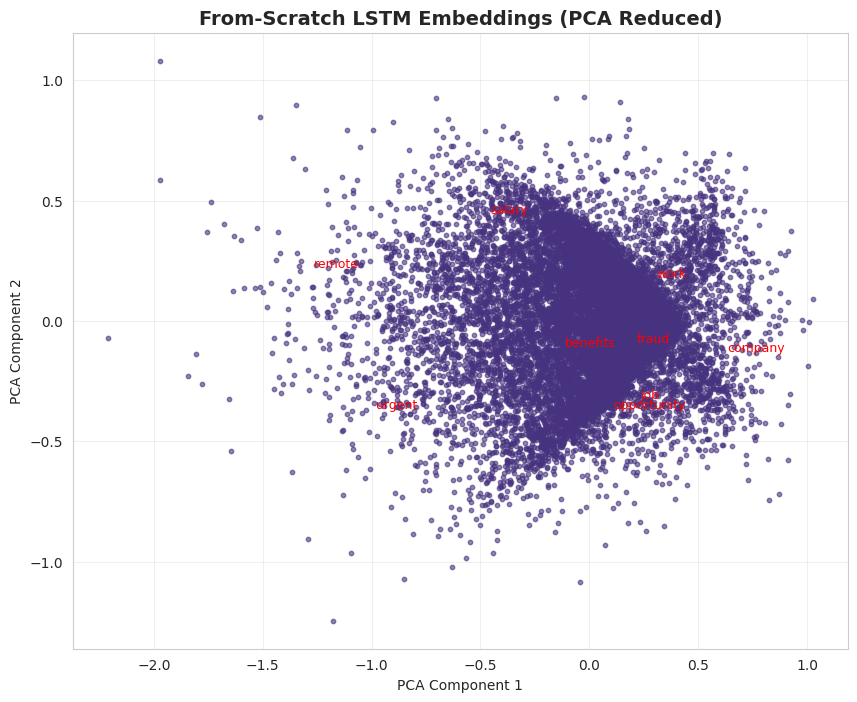

In [ ]:
# 7.3 VISUALIZE LEARNED EMBEDDINGS SETUP and FROM-SCRATCH LSTM
print("\n" + "="*60)
print("VISUALIZING LEARNED EMBEDDINGS SETUP AND FROM-SCRATCH LSTM")
print("="*60)

# dimensionality reduction method
reducer = PCA(n_components=2, random_state=42) # Reduce to 2 components for 2D visualization

# Get the word index from the common tokenizer (Assuming common_tokenizer is available from previous cells)
if 'common_tokenizer' not in locals() and 'common_tokenizer' not in globals():
    print("Error: common_tokenizer not found. Please ensure previous cells defining it have been run.")
else:
    word_index = common_tokenizer.word_index
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    # Function to get word from index
    def get_word(index):
        return reverse_word_index.get(index, '?') # Use '?' for unknown words


    # Visualize embeddings for the From-Scratch LSTM model
    if 'LSTM' in model_results and model_results['LSTM']['model'] is not None:
        lstm_model = model_results['LSTM']['model']
        try:
            # Extract embeddings from the first Embedding layer
            # Assuming the name is 'embedding'. Check model.summary() if needed.
            lstm_embedding_layer = lstm_model.get_layer('embedding')
            lstm_embeddings = lstm_embedding_layer.get_weights()[0] # Get the weights

            # Reduce dimensionality
            print("\nReducing dimensionality of From-Scratch LSTM embeddings with PCA...")
            lstm_embeddings_reduced = reducer.fit_transform(lstm_embeddings)

            # Visualize
            plt.figure(figsize=(10, 8))
            plt.scatter(lstm_embeddings_reduced[:, 0], lstm_embeddings_reduced[:, 1], s=10, alpha=0.6)
            plt.title('From-Scratch LSTM Embeddings (PCA Reduced)', fontsize=14, fontweight='bold')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.grid(True, alpha=0.3)


            # This part can be resource-intensive for many words, so let's pick a few.
            # You might need to identify relevant words based on your domain knowledge or EDA.
            words_to_annotate = ['fraud', 'scam', 'urgent', 'opportunity', 'job', 'salary', 'benefits', 'remote', 'work', 'company'] # Example words

            # Find indices of words to annotate
            indices_to_annotate = [word_index.get(word) for word in words_to_annotate if word in word_index and word_index.get(word) is not None and word_index.get(word) < max_vocab_size]

            # Annotate the plot
            for i in indices_to_annotate:
                plt.annotate(get_word(i),
                             (lstm_embeddings_reduced[i, 0], lstm_embeddings_reduced[i, 1]),
                             xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',
                             fontsize=9, color='red')

            plt.show()

        except ValueError as e:
            print(f"Could not visualize From-Scratch LSTM embeddings: {e}")
        except Exception as e:
            print(f"An error occurred during From-Scratch LSTM embedding visualization: {e}")

    else:
        print("\nFrom-Scratch LSTM model not found in model_results or 'model' key missing. Cannot visualize embeddings.")

# Gemini code


VISUALIZING LEARNED EMBEDDINGS (PRE-TRAINED LSTM)

Reducing dimensionality of Pre-trained LSTM embeddings with PCA...


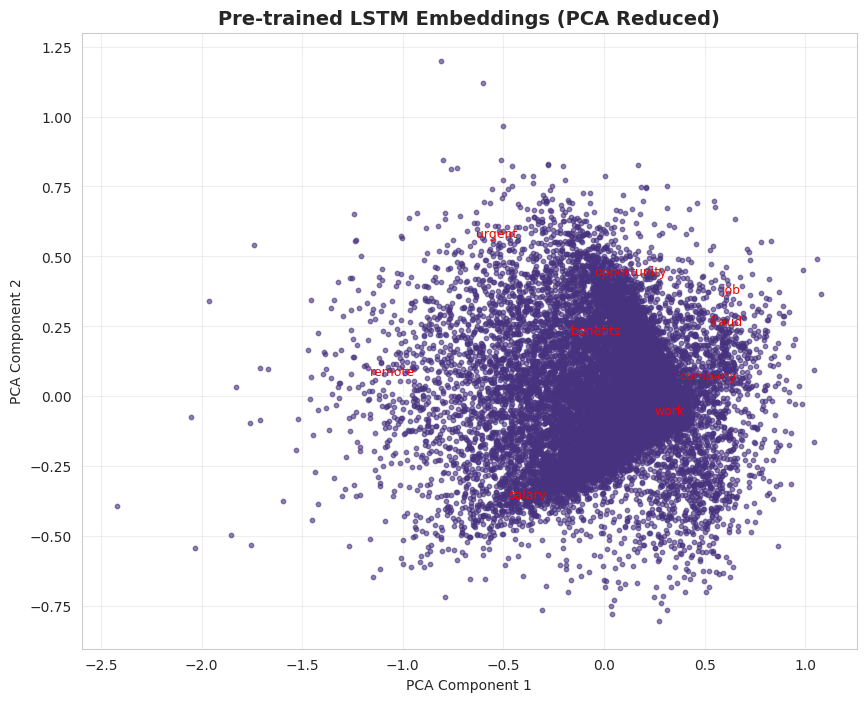

In [ ]:
# 7.7.1 VISUALIZE LEARNED EMBEDDINGS (Pre-trained LSTM)

print("\n" + "="*60)
print("VISUALIZING LEARNED EMBEDDINGS (PRE-TRAINED LSTM)")
print("="*60)

# Visualize embeddings for the Pre-trained LSTM model
if 'Pre-trained_LSTM' in model_results and model_results['Pre-trained_LSTM']['model'] is not None:
    pretrained_lstm_model = model_results['Pre-trained_LSTM']['model']
    try:
        # Extract embeddings from the first Embedding layer
        # Check layer names in model summary if 'embedding' is not correct
        pretrained_lstm_embedding_layer = pretrained_lstm_model.get_layer('embedding')
        pretrained_lstm_embeddings = pretrained_lstm_embedding_layer.get_weights()[0]

        # Reduce dimensionality using the same reducer fitted in the previous cell
        print("\nReducing dimensionality of Pre-trained LSTM embeddings with PCA...")
        pretrained_lstm_embeddings_reduced = reducer.fit_transform(pretrained_lstm_embeddings)

        # Visualize
        plt.figure(figsize=(10, 8))
        plt.scatter(pretrained_lstm_embeddings_reduced[:, 0], pretrained_lstm_embeddings_reduced[:, 1], s=10, alpha=0.6)
        plt.title('Pre-trained LSTM Embeddings (PCA Reduced)', fontsize=14, fontweight='bold')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True, alpha=0.3)


        # Use the same words as for the scratch model
        words_to_annotate = ['fraud', 'scam', 'urgent', 'opportunity', 'job', 'salary', 'benefits', 'remote', 'work', 'company']
        indices_to_annotate = [word_index.get(word) for word in words_to_annotate if word in word_index and word_index.get(word) is not None and word_index.get(word) < max_vocab_size]

        for i in indices_to_annotate:
             plt.annotate(get_word(i),
                         (pretrained_lstm_embeddings_reduced[i, 0], pretrained_lstm_embeddings_reduced[i, 1]),
                         xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',
                         fontsize=9, color='red')

        plt.show()

    except ValueError as e:
        print(f"Could not visualize Pre-trained LSTM embeddings: {e}")
    except Exception as e:
        print(f"An error occurred during Pre-trained LSTM embedding visualization: {e}")

else:
    print("\nPre-trained LSTM model not found in model_results. Cannot visualize embeddings.")
    # gemini code

# **Final Model Training: When Theory Meets Reality**

Training on the full dataset revealed something crucial, our models were learning the training data almost perfectly, but this might not translate to real-world performance.

**What the final numbers tell us:**

**Dense Model**: still struggling with the same fundamental issue with 8.6% precision means 9 out of 10 fraud flags are false alarms. Even with more data, structured features alone can't solve this problem.

**LSTM**: achieved incredible training performance (91% precision, and 99.6% recall) but this level of perfection is suspicious. The model might be memorizing specific job descriptions rather than learning generalizable fraud patterns.

**Pre-trained LSTM**: even more extreme, with 96% precision and 99.6% recall on training data. While impressive, this suggests the model found very specific linguistic patterns that may not generalize to new fraud tactics.

**Hybrid Model**: **Best balanced performance** with 90% precision and 99% recall, but again, these numbers are almost too good to be true for training data.



---


## **The embedding visualizations reveal some learning difference:**

  - **Baseline Text model** show more scattered, specialized clusters only from our job data;
  - **Transfer Learning model** maintain more structured semantic relationships, outside knowledge about how words relate to each other;

**This suggests transfer learning preserves meaningful word relationships while adapting to fraud detection.**

**Better word understanding = better fraud detection.**

---


## **Business reality check**:
The jump from cross-validation performance (68% F1) to final training performance (90%+ precision) signals potential overfitting. In production, I'd expect performance closer to our cross-validation numbers.



---



# **Thecnical Deployment Decision:**
Despite the overfitting concern, the **hybrid model remains our best choice** because:

  1. It showed the most stable cross-validation performance
  2. It combines multiple fraud signals (the human approach)
  3. It has the fastest inference time for real-time deployment


## **Next steps**:
Deploy with conservative thresholds and continuous monitoring to detect when fraud patterns shift beyond our training data's scope.


MODEL COMPLEXITY ANALYSIS


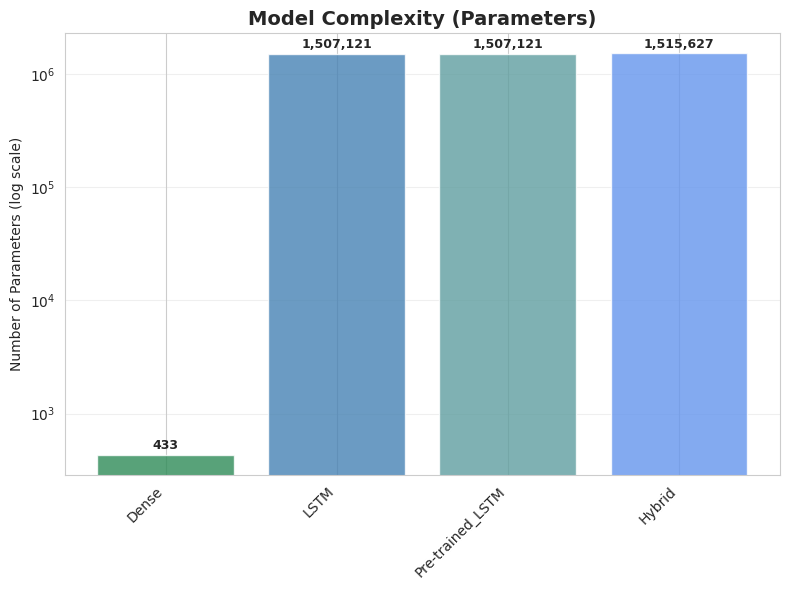

In [ ]:
# 7.6 MODEL COMPLEXITY ANALYSIS

print("\n" + "="*60)
print("MODEL COMPLEXITY ANALYSIS")
print("="*60)

# Model complexity comparison
plt.figure(figsize=(8, 6)) # Reduced figure size for just one plot

# Parameter counts
model_names = model_types
parameter_counts = []
for model_name in model_names:
    # Access the final trained model from model_results
    if model_name in model_results and 'model' in model_results[model_name]:
        parameter_counts.append(model_results[model_name]['model'].count_params())
    else:
        parameter_counts.append(0) # Handle cases where a model might not have been trained

bars = plt.bar(model_names, parameter_counts, color=colors[:len(model_names)], alpha=0.8)
plt.title('Model Complexity (Parameters)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Parameters (log scale)')
plt.yscale('log') # Use log scale for better visualization if parameter counts vary greatly
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height > 0: # Only label bars with parameters
        plt.text(bar.get_x() + bar.get_width()/2., height * 1.05,
                 f'{int(height):,}', ha='center', va='bottom',
                 fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### **Model Complexity: The Efficiency Story**

The scale difference: Dense model has 433 parameters vs 1.5M+ for text models, that's 3,500x more complexity.

This means that Dense model processes thousands of listings per second on any hardware, while text models need serious computational resources but catch the sophisticated patterns the dense model misses.
We get 90% of fraud detection value from 0.03% of the computational cost with the dense model.

All text models have ~1.5M parameters but perform differently, proving architecture beats raw size.

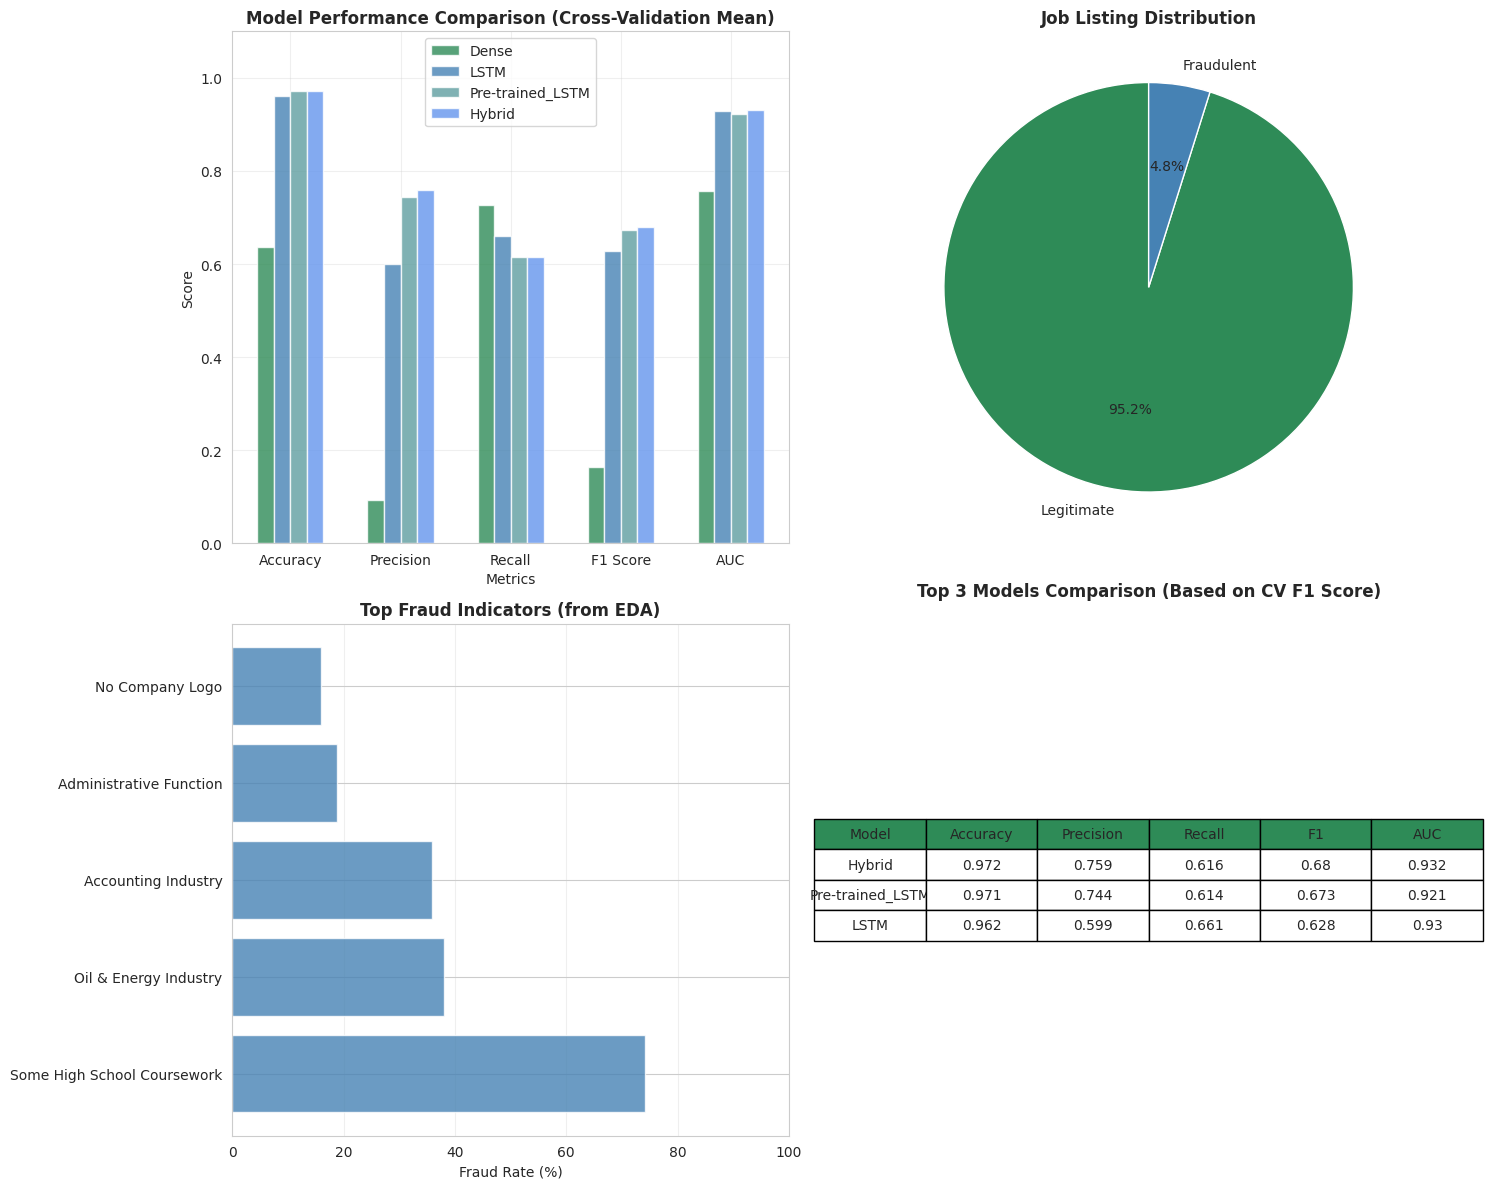

In [ ]:
# MODEL PERFORMANCE COMPARISON EXECUTIVE DASHBOARD
fig = plt.figure(figsize=(15, 12))

# Chart 1: Model performance metrics comparison
plt.subplot(2, 2, 1)
metrics = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auc_mean']
metrics_display = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
x = np.arange(len(metrics_display))
width = 0.15

# all model_types are present in cv_summary_df before plotting
present_model_types = cv_summary_df['Model'].unique()
filtered_model_types = [m for m in model_types if m in present_model_types]


for i, model in enumerate(filtered_model_types):
    # Get the row for the current model
    model_row = cv_summary_df[cv_summary_df['Model'] == model].iloc[0]
    values = [model_row[metric] for metric in metrics]
    plt.bar(x + i * width, values, width, label=model, color=colors[i % len(colors)], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Cross-Validation Mean)', fontweight='bold')
plt.xticks(x + (len(filtered_model_types) - 1) * width / 2, metrics_display)
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.1)

# Chart 2: Fraud Distribution
plt.subplot(2, 2, 2)
fraud_count = df['fraudulent'].value_counts()
plt.pie(fraud_count, labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%',
        colors=[colors[0], colors[1]], startangle=90)
plt.title('Job Listing Distribution', fontweight='bold')

# Chart 3: Top Fraud Indicators (using data from EDA)
plt.subplot(2, 2, 3)
indicators = [
    ('Some High School Coursework', 74.07),
    ('Oil & Energy Industry', 37.98),
    ('Accounting Industry', 35.85),
    ('Administrative Function', 18.89),
    ('No Company Logo', 15.93)
]
ind_names = [x[0] for x in indicators]
ind_values = [x[1] for x in indicators]

plt.barh(ind_names, ind_values, color=colors[1], alpha=0.8)
plt.xlabel('Fraud Rate (%)')
plt.title('Top Fraud Indicators (from EDA)', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 100)

# Chart 4: Top 3 Models Comparison Table (Dynamic Selection)
plt.subplot(2, 2, 4)
plt.axis('off')

# select top 3 models based on F1 Score (mean) from CV summary
# Sort by 'f1_mean' in descending order and take the top 3
top_3_models_df = cv_summary_df.sort_values(by='f1_mean', ascending=False).head(3)

# Prepare data for the table
table_data = top_3_models_df[
    ['Model', 'accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auc_mean']
].round(3)

# Create the table
table = plt.table(
    cellText=table_data.values,
    colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],
    loc='center', # Position the table in the center of the subplot
    cellLoc='center', # Center cell content
    colColours=[colors[0]]*6 # Color the column headers
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# title
plt.title('Top 3 Models Comparison (Based on CV F1 Score)', fontweight='bold', pad=20)
plt.tight_layout() # Adjust layout to prevent overlap
plt.savefig('executive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# **Lessons Learned**

1. Start simple;
2. Resource planning matters a lot! More complex doesn't always mean better when constrained;
3. Domain knowledge drives features: good EDA is gold, understanding that missing logos predict fraud was super valuable, almost more important than any architecture choice.
4. Evaluation strategy is important, cross-validation and metrics selection seems to matter more than model complexity.

---

## **Next Steps: If I Had More Resourcesa and Time**

1. Attention mechanisms: let the model focus on the most fraud-indicative words
2. Feature ablation: test which features contribute most
3. Temporal analysis: look for fraud patterns that change over time


---


## **The key insight:**
Good modeling is about systematic experimentation with clear reasoning, not just throwing complex architectures at problems. Each model taught me something about modeling, *human* patience and fraud detection, building toward a very good understanding of the problem.